# **Splines - Beginner Friendly Introduction**

- This notebook builds intuition for splines by starting from simple piecewise polynomials and gradually adding smoothness, constraints, and statistical ideas until we reach cubic and smoothing splines.

## Part 1: Piecewise Polynomial

A **piecewise polynomial** is a function that:
- Uses different polynomials on different intervals
- Switches polynomials at predefined points called **knots**
- Instead of one complicated global function, we use **simple local models**.

> Key idea: *local control beats global complexity*
---
#### **Mathematical Definition**

Let the knots be:

$$
t_0 < t_1 < \dots < t_K
$$

A piecewise polynomial function $f(x)$ is defined as:

$$
f(x) =
\begin{cases}
p_0(x), & t_0 \le x < t_1 \\
p_1(x), & t_1 \le x < t_2 \\
\vdots \\
p_{K-1}(x), & t_{K-1} \le x \le t_K
\end{cases}
$$

where each $p_j(x)$ is a polynomial (possibly of the same degree).


---
#### *This is the data we are going to use throughout the notebook*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

x = np.linspace(0, 10, 20)
y = np.sin(x) + 0.2 * np.random.randn(len(x))

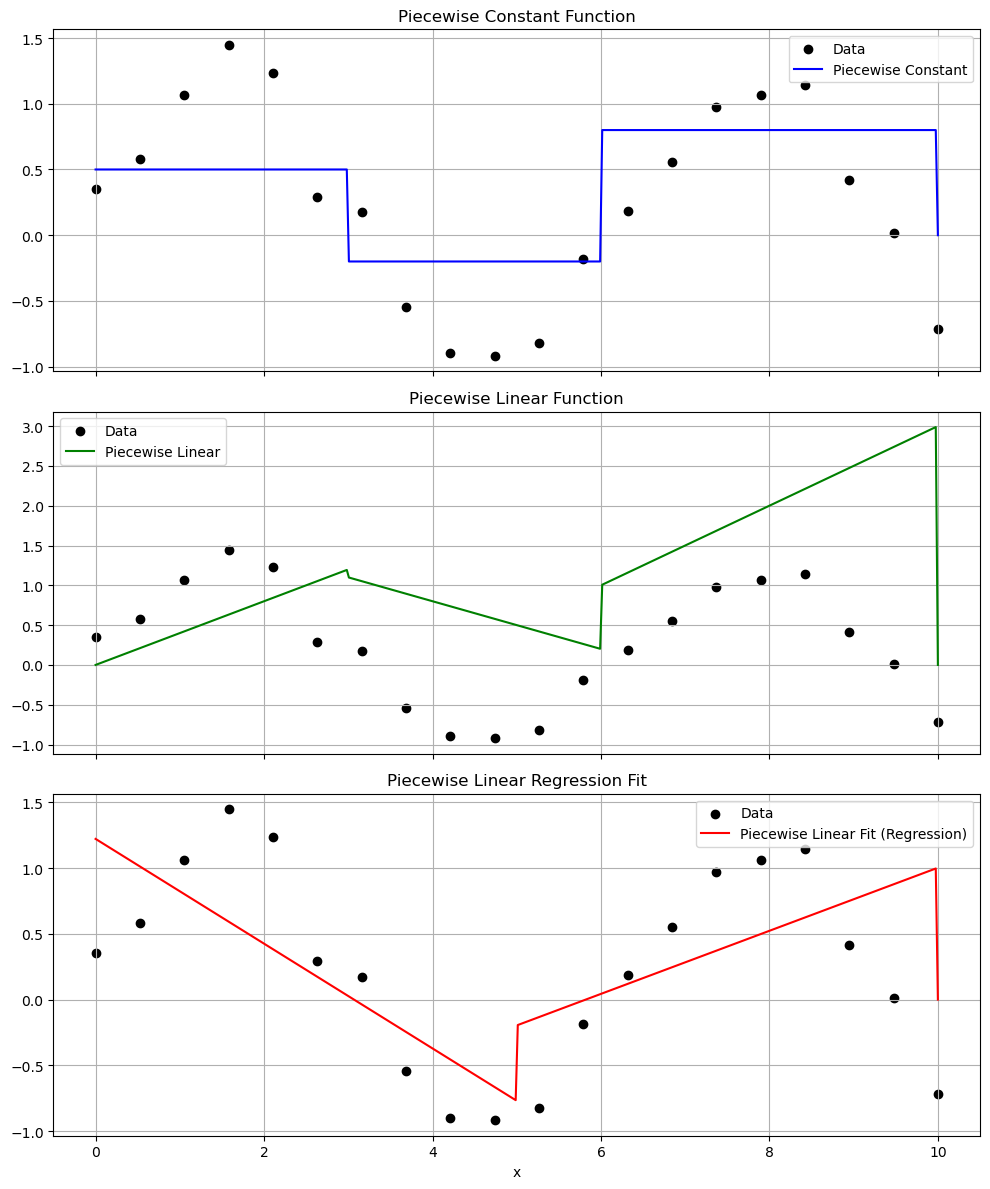

In [6]:
from sklearn.linear_model import LinearRegression


# Piecewise Constant Function
knots_const = [0, 3, 6, 10]
values_const = [0.5, -0.2, 0.8]

def piecewise_constant(x, knots, values):
    y_out = np.zeros_like(x)
    for i in range(len(knots)-1):
        mask = (x >= knots[i]) & (x < knots[i+1])
        y_out[mask] = values[i]
    return y_out

xx = np.linspace(0, 10, 400)
yy_const = piecewise_constant(xx, knots_const, values_const)


# Piecewise Linear Function
slopes_linear = [0.4, -0.3, 0.5]
intercepts_linear = [0.0, 2.0, -2.0]
knots_linear = [0, 3, 6, 10]

def piecewise_linear(x, knots, slopes, intercepts):
    y_out = np.zeros_like(x)
    for i in range(len(knots)-1):
        mask = (x >= knots[i]) & (x < knots[i+1])
        y_out[mask] = slopes[i]*x[mask] + intercepts[i]
    return y_out

yy_linear = piecewise_linear(xx, knots_linear, slopes_linear, intercepts_linear)


# Piecewise Linear Fit to Data (manual regression)
knots_fit = [0, 5, 10]
yy_fit = np.zeros_like(xx)

for i in range(len(knots_fit)-1):
    mask_data = (x >= knots_fit[i]) & (x < knots_fit[i+1])
    mask_plot = (xx >= knots_fit[i]) & (xx < knots_fit[i+1])

    model = LinearRegression()
    model.fit(x[mask_data].reshape(-1,1), y[mask_data])
    yy_fit[mask_plot] = model.predict(xx[mask_plot].reshape(-1,1))


# Plots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# Piecewise Constant
axes[0].scatter(x, y, color='black', label='Data')
axes[0].plot(xx, yy_const, color='blue', label='Piecewise Constant')
axes[0].set_title('Piecewise Constant Function')
axes[0].legend()
axes[0].grid(True)

# Piecewise Linear
axes[1].scatter(x, y, color='black', label='Data')
axes[1].plot(xx, yy_linear, color='green', label='Piecewise Linear')
axes[1].set_title('Piecewise Linear Function')
axes[1].legend()
axes[1].grid(True)

# Piecewise Linear Fit (Regression)
axes[2].scatter(x, y, color='black', label='Data')
axes[2].plot(xx, yy_fit, color='red', label='Piecewise Linear Fit (Regression)')
axes[2].set_title('Piecewise Linear Regression Fit')
axes[2].legend()
axes[2].grid(True)

plt.xlabel('x')
plt.tight_layout()
plt.show();

## Part 2: Natural Cubic Splines

A **natural cubic spline** is a piecewise cubic polynomial that:

- Passes through all the data points (interpolation)
- Has **continuous first and second derivatives** at interior knots
- Has **zero second derivative at the endpoints**, which makes the ends “relaxed”

**Why use it:**  
- Produces a smooth curve without sharp kinks  
- Avoids the oscillations of high-degree global polynomials  
- Simple boundary conditions make it easy to implement

---

#### **Mathematical Definition**
For knots $t_0 < t_1 < \dots < t_n$, the spline on each interval $[t_i, t_{i+1}]$ is:

$$
S_i(x) = a_i + b_i(x - t_i) + c_i(x - t_i)^2 + d_i(x - t_i)^3
$$

with conditions:

1. Interpolation: $S_i(t_i) = y_i$, $S_i(t_{i+1}) = y_{i+1}$  
2. Smoothness: $S_i'(t_{i+1}) = S_{i+1}'(t_{i+1})$, $S_i''(t_{i+1}) = S_{i+1}''(t_{i+1})$  
3. Natural boundary: $S_0''(t_0) = 0$, $S_{n-1}''(t_n) = 0$

> These conditions guarantee a smooth curve through all points.

In [8]:
from scipy.interpolate import CubicSpline

np.random.seed(0)
x = np.linspace(0, 10, 20)
y = np.sin(x) + 0.2*np.random.randn(len(x))

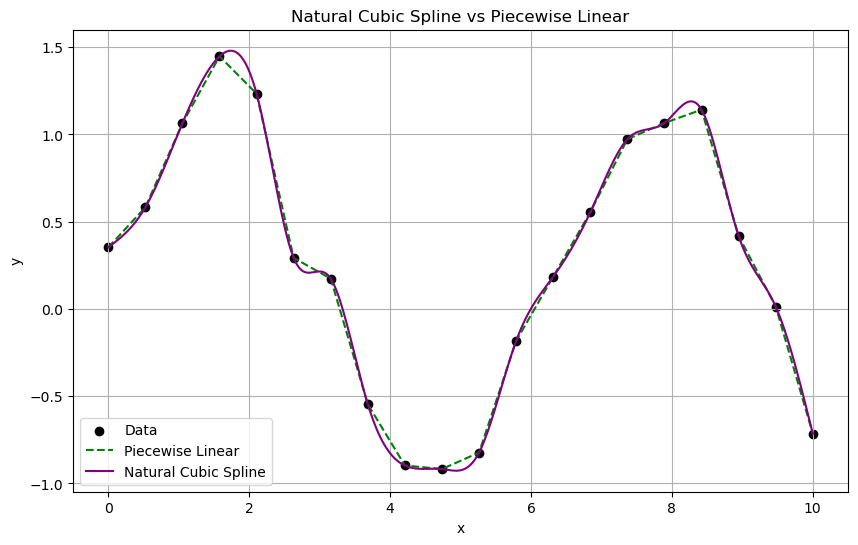

In [9]:
# Piecewise Linear (for comparison)
xx = np.linspace(0, 10, 400)
yy_linear = np.interp(xx, x, y)

# Natural Cubic Spline
cs = CubicSpline(x, y, bc_type='natural')
yy_cubic = cs(xx)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='black', label='Data')
plt.plot(xx, yy_linear, color='green', linestyle='--', label='Piecewise Linear')
plt.plot(xx, yy_cubic, color='purple', label='Natural Cubic Spline')
plt.title('Natural Cubic Spline vs Piecewise Linear')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

## Part 3: Smoothing Splines

What is a Smoothing Spline?

A **smoothing spline** is a flexible extension of cubic splines for **noisy data**:

- Unlike natural cubic splines, it **does not pass exactly through all points**
- Balances **fit to data** and **smoothness** with a **smoothing parameter** $\lambda$:

$$
\min_f \sum_{i=1}^n (y_i - f(x_i))^2 + \lambda \int (f''(x))^2 dx
$$

- First term: keeps the curve close to the data  
- Second term: penalizes roughness (large curvature)  
- $\lambda = 0$ → behaves like cubic spline interpolation  
- $\lambda \to \infty$ → approaches a straight line  

> Intuition: *Smoothing splines “trust the trend” rather than every noisy point.*

---

In [11]:
from scipy.interpolate import CubicSpline, UnivariateSpline

np.random.seed(0)
x = np.linspace(0, 10, 20)
y = np.sin(x) + 0.2*np.random.randn(len(x))

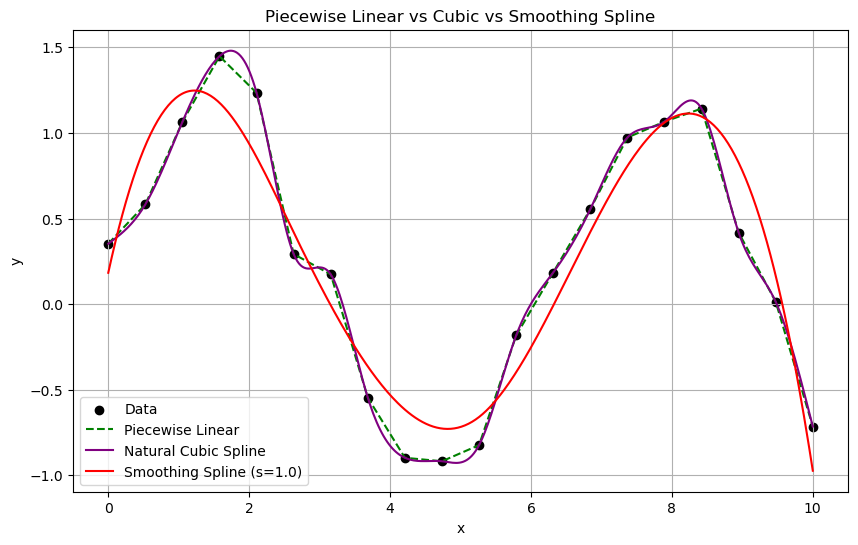

In [12]:
xx = np.linspace(0, 10, 400)

# Piecewise Linear
yy_linear = np.interp(xx, x, y)

# Natural Cubic Spline
cs = CubicSpline(x, y, bc_type='natural')
yy_cubic = cs(xx)

# Smoothing Spline
ss = UnivariateSpline(x, y, s=1.0)  # s controls smoothness
yy_smooth = ss(xx)

# Plot
plt.figure(figsize=(10,6))
plt.scatter(x, y, color='black', label='Data')
plt.plot(xx, yy_linear, color='green', linestyle='--', label='Piecewise Linear')
plt.plot(xx, yy_cubic, color='purple', label='Natural Cubic Spline')
plt.plot(xx, yy_smooth, color='red', label='Smoothing Spline (s=1.0)')
plt.title('Piecewise Linear vs Cubic vs Smoothing Spline')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()